# Functions: 
1. Extract weather data for the same periods we have extraction data from IBM PAIRS: 
- Rainfall
- Temperature 
2. Map the weather data to yield data 
3. Correlate the weather data to yield 
4. Predict yield or water point use based on weather? 


# Imports 

In [117]:
#Data imports  
import pandas as pd, requests
from datetime import datetime, timedelta
from scipy import stats
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

#ML imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import concatenate

#Plot imports
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook



In [118]:
# Import flow volume for location as datafraimes
#5691681, 5691708, 5691715, 8037020, 21082780

df_vol = pd.read_csv('C:/Users/NATHANWANGUSI/Documents/GitHub/groundwater-advisor/flowtimeSeriesAnalysis/data/volume/5691605.csv')


# Indexing

In [119]:
#Index from 1 to last value of the array
start_index=0
end_index =-1

start_date = (df_vol['datetime'].iloc[start_index])
end_date = df_vol['datetime'].iloc[end_index]

start_datetime = (datetime.strptime(start_date, '%d/%m/%Y')- timedelta(days=1))
end_datetime = datetime.strptime(end_date, '%d/%m/%Y')

In [120]:
print(start_datetime)

2017-09-05 00:00:00


In [121]:
print(end_datetime)

2019-07-05 00:00:00


In [122]:
start_datetimestr = start_datetime.strftime("%Y-%m-%d %H:%M:%S")
end_datetimestr = end_datetime.strftime("%Y-%m-%d %H:%M:%S")

In [123]:
df_vol.datetime = pd.to_datetime(df_vol['datetime'], format="%d/%m/%Y")
df_vol.set_index('datetime', inplace=True)
df_vol.describe()

,volume
count,668.000000
mean,33.750749
std,43.229398
min,0.000000
25%,0.000000
50%,13.300000
75%,48.350000
max,206.700000


In [124]:
#Provide inputs 
pairs_auth = ('nathanwangusi@ke.ibm.com', 'NSj6nAGaCzbZ4tB4teSY')

lat = 2.029
long = 35.148
cood = [lat,long]

start_time = start_datetimestr
end_time = end_datetimestr


In [125]:
print(start_datetime)
print(end_datetime)

2017-09-05 00:00:00
2019-07-05 00:00:00


In [126]:
print(start_time)
print(end_time)

2017-09-05 00:00:00
2019-07-05 00:00:00


IBM PAIRS query for 24 h daily global weather datasets : 

1. Precipitation (10 day weather forecast (ECMWF))
ID: 49168,  temporal range available:  2015-01-10 to 2019-06-14

2. Temperature (Global weather- NOAA CPC)
ID: 49554, temporal Range available:  1979-01-01 to 2019-07-21

In [127]:
#Daily Precip Derived from ECMWF Reanalysis
#ID: 49019

query = {
    "layers" : [
        {"type" : "raster", "id" : "49168"}
    ],
    
    #Pass the start and end times from the flow volume file to obtain precipitation for the same duration 
    "spatial" : {"type" : "point",  "coordinates" : cood },
    "temporal" : {"intervals" : [
        {"start" :start_time , "end" : end_time}
    ]}
}
api_response = requests.post(
    'https://pairs.res.ibm.com/v2/query', auth = pairs_auth, json = query
)
pairs_data = pd.DataFrame(api_response.json()['data'])

pairs_data['datetime'] = pd.to_datetime(pairs_data['timestamp'] * 1e6)

df_prec=pairs_data.drop(['dataset','latitude','layerId','layerName','longitude','timestamp'], axis=1)
df_prec.datetime = pd.to_datetime(df_prec['datetime'].astype(str), format='%Y-%m-%d')
df_prec.set_index('datetime', inplace=True)
df_prec.rename(columns={'value':'prec'}, inplace=True)
df_prec.describe()

,prec
count,668
unique,577
top,0.0
freq,92


In [128]:
# Maximum Temperature Derived from - Global weather (NOAA CPC)
# Justification: The hotest point on the day has the highest heat stress from ET 
#ID: 49554
            
query = {
    "layers" : [
        {"type" : "raster", "id" : "49554"}
    ],
 
    #Pass the start and end times from the flow volume file to obtain temperature for the same duration    
    "spatial" : {"type" : "point",  "coordinates" : cood },
    "temporal" : {"intervals" : [
        {"start" :start_time , "end" : end_time}
    ]}
}
api_response = requests.post(
    'https://pairs.res.ibm.com/v2/query', auth = pairs_auth, json = query
)
pairs_data = pd.DataFrame(api_response.json()['data'])
pairs_data['datetime'] = pd.to_datetime(pairs_data['timestamp'] * 1e6)

df_temp=pairs_data.drop(['dataset','latitude','layerId','layerName','longitude','timestamp'], axis=1)
df_temp.datetime = pd.to_datetime(df_temp['datetime'].astype(str), format='%Y-%m-%d')
df_temp.set_index('datetime', inplace=True)
df_temp.rename(columns={'value':'temp'}, inplace=True)

df_temp.describe()

,temp
count,668
unique,668
top,32.69819641113281
freq,1


# Plots

Text(0, 0.5, 'Precipitation - mm')

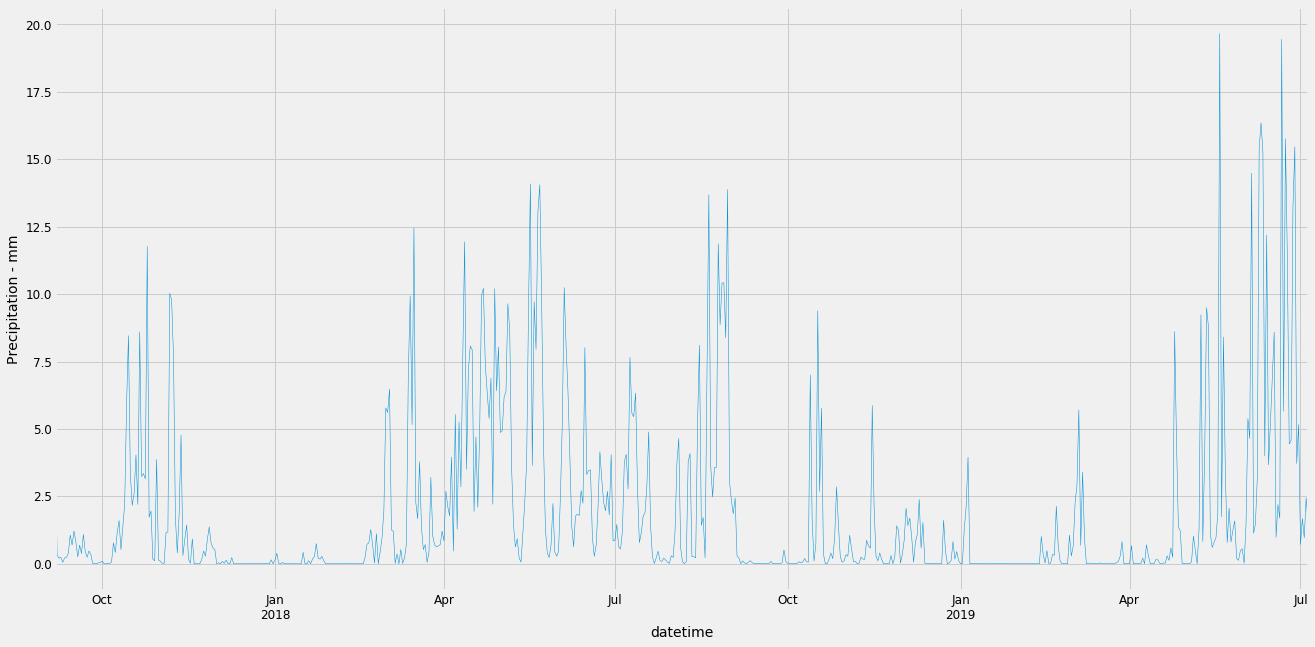

In [129]:
# Precipitation 
df_prec=df_prec.astype(float)
ax= df_prec['prec'].plot(linewidth=0.5, figsize=(20,10));
ax.set_ylabel('Precipitation - mm')

Text(0, 0.5, 'Temperature - degC')

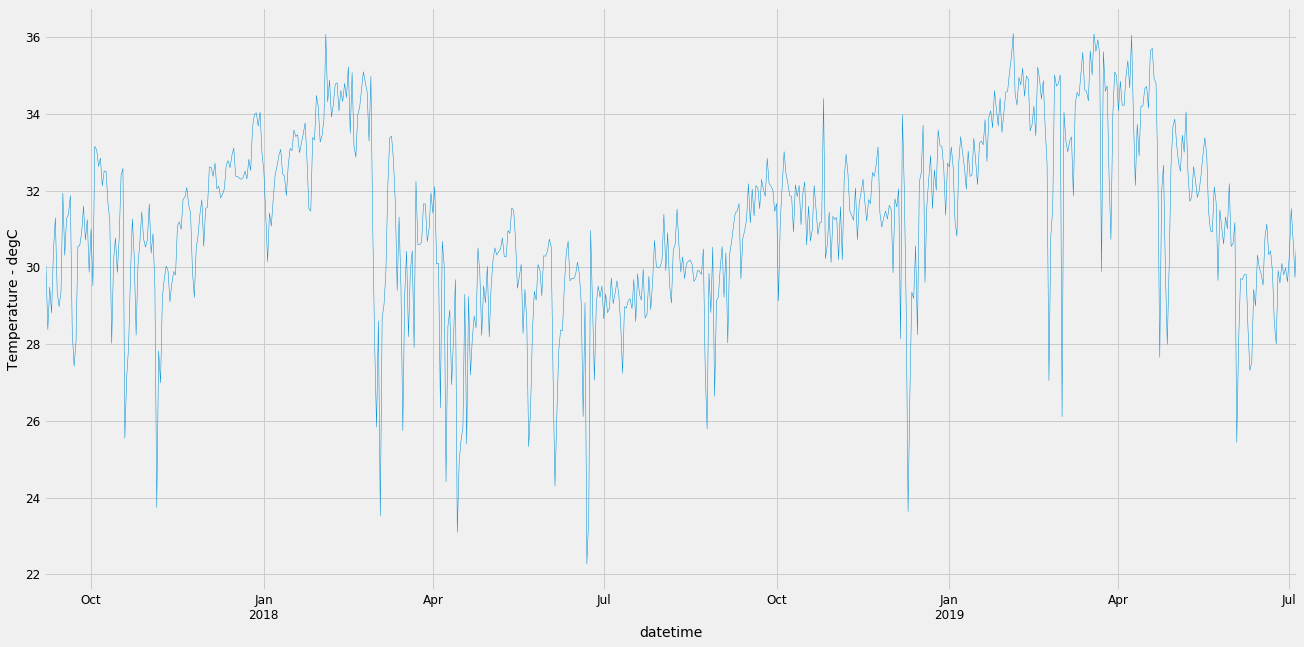

In [130]:
#Temperature 
df_temp=df_temp.astype(float)
ax= df_temp['temp'].plot(linewidth=0.5, figsize=(20,10));
ax.set_ylabel('Temperature - degC')

Text(0, 0.5, 'Yield- m3')

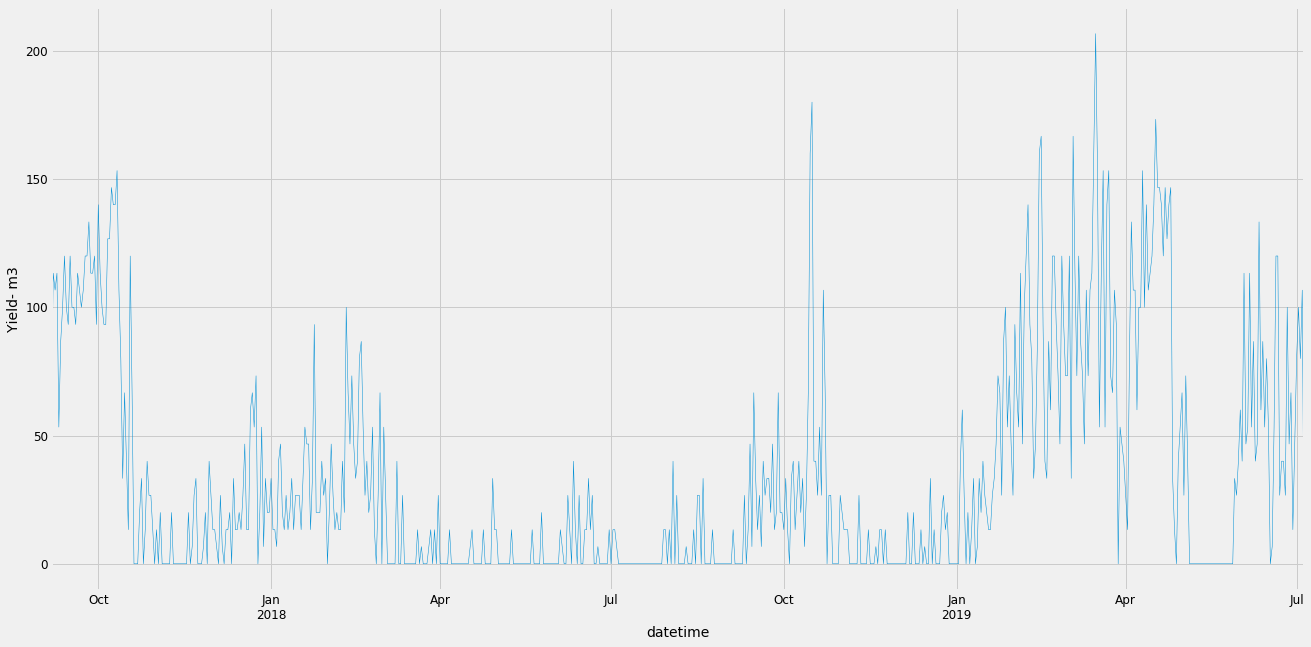

In [131]:
#Volume
df_vol=df_vol.astype(float)
ax= df_vol['volume'].plot(linewidth=0.5, figsize=(20,10));
ax.set_ylabel('Yield- m3')

In [132]:
df_weather= pd.merge(df_prec,df_temp, on='datetime')
df_weather.head()

,prec,temp
datetime,,
2017-09-06,5.134328,30.401609
2017-09-07,0.329856,30.041592
2017-09-08,0.207937,28.380363
2017-09-09,0.241048,29.483528
2017-09-10,0.053119,28.812807


In [133]:
df_weathervol= pd.merge(df_vol, df_weather, on='datetime')
df_weathervol.head()

,volume,prec,temp
datetime,,,
2017-09-06,53.3,5.134328,30.401609
2017-09-07,113.3,0.329856,30.041592
2017-09-08,106.7,0.207937,28.380363
2017-09-09,113.3,0.241048,29.483528
2017-09-10,53.3,0.053119,28.812807


Text(0, 0.5, 'Value')

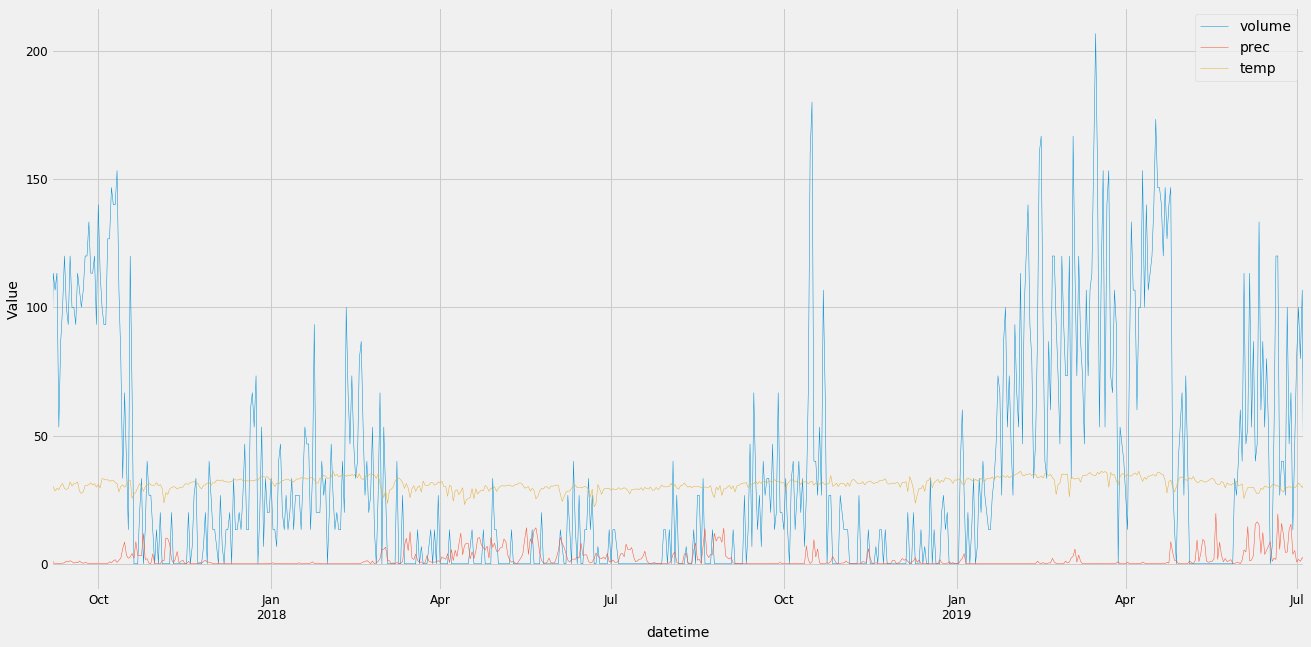

In [134]:
#Weather and volume plot
df_weathervol=df_weathervol.astype(float)
ax= df_weathervol.plot(linewidth=0.5,  figsize=(20,10));
ax.set_ylabel('Value')

# LSTM Data Preparation 

In [135]:
#Save dataset as csv

csv_weathervol= df_weathervol.to_csv('C:/Users/NATHANWANGUSI/Documents/GitHub/groundwater-advisor/flowtimeSeriesAnalysis/data/aggr/weathervol.csv')

# load dataset
dataset = read_csv('C:/Users/NATHANWANGUSI/Documents/GitHub/groundwater-advisor/flowtimeSeriesAnalysis/data/aggr/weathervol.csv', header=0, index_col=0)
values = dataset.values
print(values)

[[ 53.3          5.13432789  30.40160942]
 [113.3          0.3298555   30.04159164]
 [106.7          0.20793672  28.38036346]
 ...
 [ 80.           0.96960598  30.70386505]
 [106.7          2.44569612  29.7440033 ]
 [  0.           1.53190243  30.93012238]]


In [136]:
from pandas import DataFrame
from pandas import concat

# load dataset
dataset = read_csv('C:/Users/NATHANWANGUSI/Documents/GitHub/groundwater-advisor/flowtimeSeriesAnalysis/data/aggr/weathervol.csv', header=0, index_col=0)
values = dataset.values

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


pd.DataFrame(data=scaled).head()

,0,1,2
0,0.257862,0.261148,0.588199
1,0.548137,0.016777,0.562139
2,0.516207,0.010576,0.441892
3,0.548137,0.012260,0.521744
4,0.257862,0.002702,0.473194


In [137]:
#Convert series to supervised learning problem


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# aggregate
    agg = concat(cols, axis=1)
    agg.columns = names

# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [138]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

#t-1 (previous day) for var1-vol, var2-prec and var3-temp, t(current day) for var1-vol. Drop t for var 2&3
#The current day volume is a the target var while previous days volume and weather are predictors. 
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.257862,0.261148,0.588199,0.548137
2,0.548137,0.016777,0.562139,0.516207
3,0.516207,0.010576,0.441892,0.548137
4,0.548137,0.012260,0.521744,0.257862
5,0.257862,0.002702,0.473194,0.419448


# Split to train and test sets


In [139]:
# split into train and test sets
values = reframed.values
n_train_days = 200 

#--clip 
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into I/0 X(t-1 (previous day) for var1-vol, var2-prec and var3-temp,) and Y
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape inputs to be 3D [samples, timesteps ahead, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(200, 1, 3) (200,) (467, 1, 3) (467,)


Train on 200 samples, validate on 467 samples
Epoch 1/80
 - 2s - loss: 0.1875 - val_loss: 0.1501
Epoch 2/80
 - 0s - loss: 0.1754 - val_loss: 0.1463
Epoch 3/80
 - 0s - loss: 0.1649 - val_loss: 0.1432
Epoch 4/80
 - 0s - loss: 0.1557 - val_loss: 0.1407
Epoch 5/80
 - 0s - loss: 0.1491 - val_loss: 0.1404
Epoch 6/80
 - 0s - loss: 0.1451 - val_loss: 0.1406
Epoch 7/80
 - 0s - loss: 0.1426 - val_loss: 0.1411
Epoch 8/80
 - 0s - loss: 0.1411 - val_loss: 0.1415
Epoch 9/80
 - 0s - loss: 0.1402 - val_loss: 0.1415
Epoch 10/80
 - 0s - loss: 0.1395 - val_loss: 0.1410
Epoch 11/80
 - 0s - loss: 0.1387 - val_loss: 0.1401
Epoch 12/80
 - 0s - loss: 0.1378 - val_loss: 0.1388
Epoch 13/80
 - 0s - loss: 0.1367 - val_loss: 0.1373
Epoch 14/80
 - 0s - loss: 0.1357 - val_loss: 0.1357
Epoch 15/80
 - 0s - loss: 0.1347 - val_loss: 0.1341
Epoch 16/80
 - 0s - loss: 0.1338 - val_loss: 0.1325
Epoch 17/80
 - 0s - loss: 0.1330 - val_loss: 0.1310
Epoch 18/80
 - 0s - loss: 0.1322 - val_loss: 0.1296
Epoch 19/80
 - 0s - loss: 0

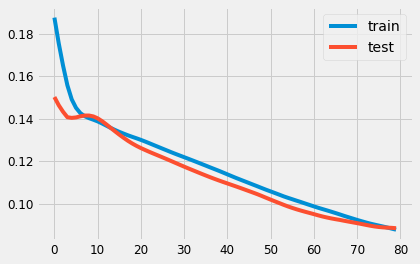

In [140]:
# design network
model = Sequential()
model.add(LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network. Error inflects at 80 epochs
history = model.fit(train_X, train_y, epochs=80, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot error loss through training epochs'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

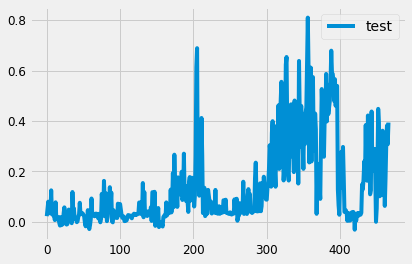

In [141]:
#make predictions
y_hat = model.predict(test_X)
plt.plot(y_hat, label='test')
plt.legend()


In [115]:
y_hat.shape

(467, 1)

In [142]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [145]:
test_X.shape[1]

3